In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
import joblib

# Load the dataset
file_path = "/Users/alonclausen/Desktop/Studie/Kandidat/Seminar/SEMINARFIN/fulldata.csv"
data = pd.read_csv(file_path)



In [2]:
# Display all column names in the dataset
print(data.columns)

Index(['SpotPriceDKK', 'from', 'to', 'temp_pca_1', 'temp_pca_2', 'temp_pca_3',
       'wind_speed_pca_1', 'wind_speed_pca_2', 'wind_speed_pca_3',
       'wind_speed_pca_4', 'wind_speed_pca_5', 'wind_speed_pca_6',
       'wind_speed_pca_7', 'wind_speed_pca_8', 'wind_speed_pca_9',
       'wind_speed_pca_10', 'wind_speed_pca_11', 'wind_speed_pca_12',
       'wind_speed_pca_13', 'wind_speed_pca_14', 'mean_wind_dir_pca_1',
       'mean_wind_dir_pca_2', 'mean_wind_dir_pca_3', 'mean_wind_dir_pca_4',
       'mean_wind_dir_pca_5', 'mean_wind_dir_pca_6', 'mean_wind_dir_pca_7',
       'mean_wind_dir_pca_8', 'mean_wind_dir_pca_9', 'mean_wind_dir_pca_10',
       'mean_wind_dir_pca_11', 'mean_wind_dir_pca_12', 'mean_wind_dir_pca_13',
       'mean_wind_dir_pca_14', 'mean_wind_dir_pca_15', 'mean_wind_dir_pca_16',
       'mean_wind_dir_pca_17', 'mean_wind_dir_pca_18', 'mean_wind_dir_pca_19',
       'mean_wind_dir_pca_20', 'mean_wind_dir_pca_21', 'mean_wind_dir_pca_22',
       'mean_wind_dir_pca_23', 'm

In [3]:
# Ensure 'from' column is in datetime format and set as index
data['from'] = pd.to_datetime(data['from'])
data = data.set_index('from')
data.index = pd.DatetimeIndex(data.index.values, freq=pd.infer_freq(data.index))

# Training data: From October 27, 2017, to July 31, 2024
train_start_date = '2017-10-27'
train_end_date = '2024-07-31'
train_data = data[(data.index >= train_start_date) & (data.index <= train_end_date)]
spot_price_train = train_data['SpotPriceDKK']

In [ ]:
# Step 1: Fit the SARIMA model with the best parameters
best_order = (2, 0, 2)  # ARIMA(5,0,0)
best_seasonal_order = (2, 0, 2, 12)  # Seasonal (2,0,0)[12]

print("Fitting SARIMA model...")
sarima_model = SARIMAX(spot_price_train, 
                       order=best_order, 
                       seasonal_order=best_seasonal_order, 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)
print("Model fitting complete.\n")
print(sarima_results.summary())

Fitting SARIMA model...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Step 2: Bulk forecast for the next 7 days (168 steps ahead)
forecast_steps = 7 * 24  # 7 days of hourly forecasts
forecast_start_date = pd.Timestamp('2024-08-01') + pd.Timedelta(hours=1)

# Generate forecast
print("Generating bulk forecast for 7 days...")
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)

# Extract forecasted mean and confidence intervals
forecast_mean = sarima_forecast.predicted_mean
forecast_conf_int = sarima_forecast.conf_int()

# Adjust forecast index to start at the forecast start date
forecast_index = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='H')
forecast_mean.index = forecast_index
forecast_conf_int.index = forecast_index

Generating bulk forecast for 7 days...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/jg/p6c6lqr91kj2q41htjb2tvsc0000gn/T/ipykernel_25891/1784111638.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='H')


In [ ]:
#Show the forecasted values and the actual values
print(forecast_mean)



2024-08-01 01:00:00    121.619692
2024-08-01 02:00:00    148.069418
2024-08-01 03:00:00    165.572732
2024-08-01 04:00:00    189.141972
2024-08-01 05:00:00    189.230440
                          ...    
2024-08-07 20:00:00      8.914230
2024-08-07 21:00:00      8.320744
2024-08-07 22:00:00      7.880845
2024-08-07 23:00:00      7.324421
2024-08-08 00:00:00      7.158678
Freq: h, Name: predicted_mean, Length: 168, dtype: float64


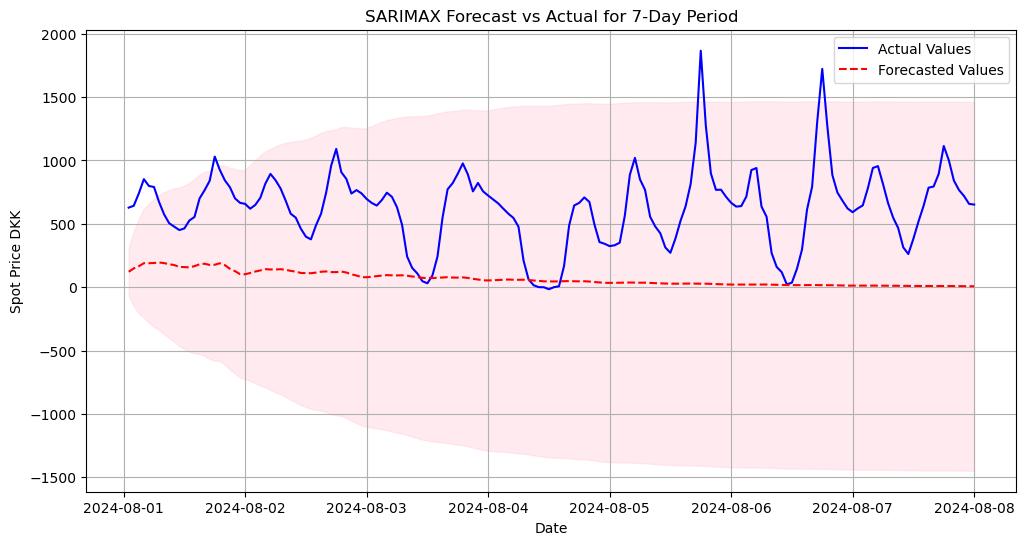

In [ ]:
# Step 3: Extract actual values for the same period
actual_values = data.loc[forecast_index, 'SpotPriceDKK']

# Step 4: Plot only the forecasted period with actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual Values", color="blue")
plt.plot(forecast_mean, label="Forecasted Values", color="red", linestyle="--")
plt.fill_between(forecast_index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMAX Forecast vs Actual for 7-Day Period")
plt.xlabel("Date")
plt.ylabel("Spot Price DKK")
plt.legend()
plt.grid()
plt.show()

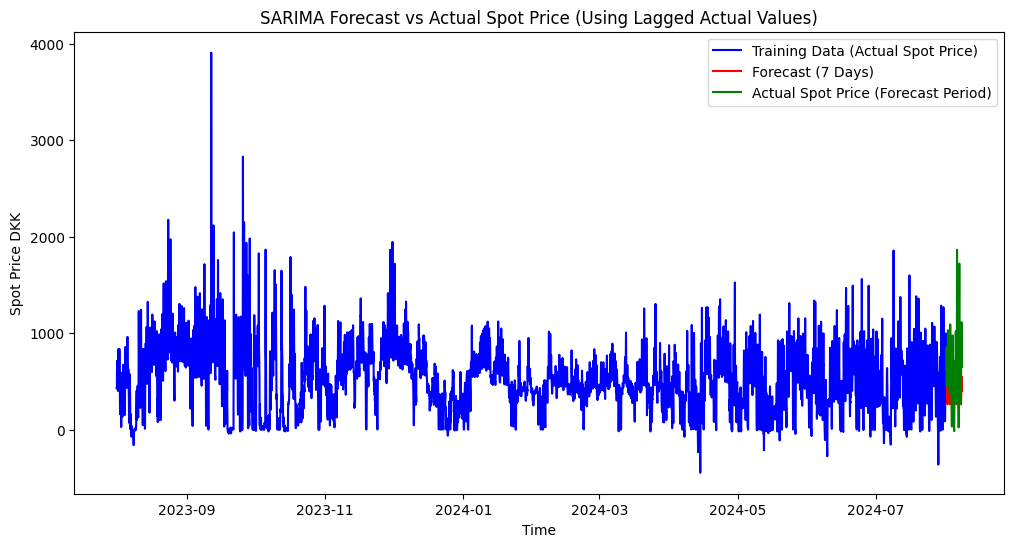

In [ ]:
# Plot the training data, forecast, and actual values
plt.figure(figsize=(12, 6))
plt.plot(spot_price_train, label='Training Data (Actual Spot Price)', color='blue')
plt.plot(forecast_values, label='Forecast (7 Days)', color='red')
if not actual_values.empty:
    plt.plot(actual_spot_price, label='Actual Spot Price (Forecast Period)', color='green')
plt.xlabel('Time')
plt.ylabel('Spot Price DKK')
plt.title('SARIMA Forecast vs Actual Spot Price (Using Lagged Actual Values)')
plt.legend()
plt.show()

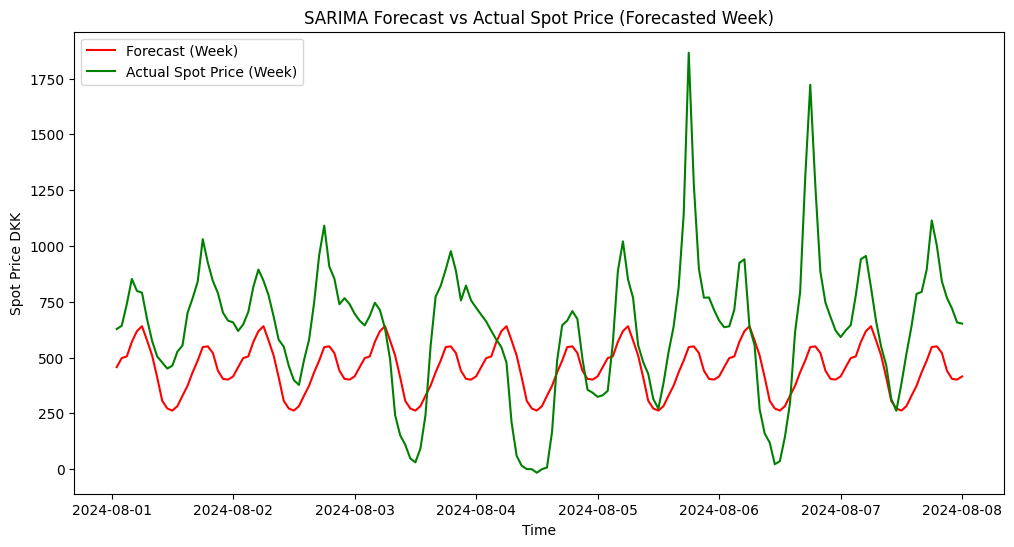

In [ ]:
# Ensure the indices are sorted
forecast_values = forecast_values.sort_index()
actual_spot_price = actual_spot_price.sort_index()

# Extract the forecasted week and corresponding actual data
forecast_week = forecast_values['2024-08-01 01:00:00':'2024-08-08 00:00:00']
actual_week = actual_spot_price['2024-08-01 01:00:00':'2024-08-08 00:00:00']

# Plot the forecasted week and actual data
plt.figure(figsize=(12, 6))
plt.plot(forecast_week, label='Forecast (Week)', color='red')
plt.plot(actual_week, label='Actual Spot Price (Week)', color='green')
plt.xlabel('Time')
plt.ylabel('Spot Price DKK')
plt.title('SARIMA Forecast vs Actual Spot Price (Forecasted Week)')
plt.legend()
plt.show()